In [1]:
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import plotting_utils as pu

from utils import city_list
from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, get_unique_loca_metrics

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

In [2]:
# Set fonts
from matplotlib import font_manager

font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### City plots

In [23]:
# Read timeseries
city = "boston"
metric_id = "max_pr"
var_id = metric_id.split('_')[1]
unit = '[mm]'

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

In [24]:
# # Filter
# df = df.query('tasmax < 50')

In [25]:
# Read return levels
stat_n_boot = 1000
nonstat_n_boot = 1000
sample_str = "_samples"
stat_fit_method = "lmom"
nonstat_fit_method = "mle"
proj_slice = "2050-2100"
hist_slice = "1950-2014"
nonstat_slice = "1950-2100"

df_nonstat = pd.read_csv(
        f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{nonstat_slice}_{nonstat_fit_method}_nonstat_nboot{nonstat_n_boot}{sample_str}.csv"
)

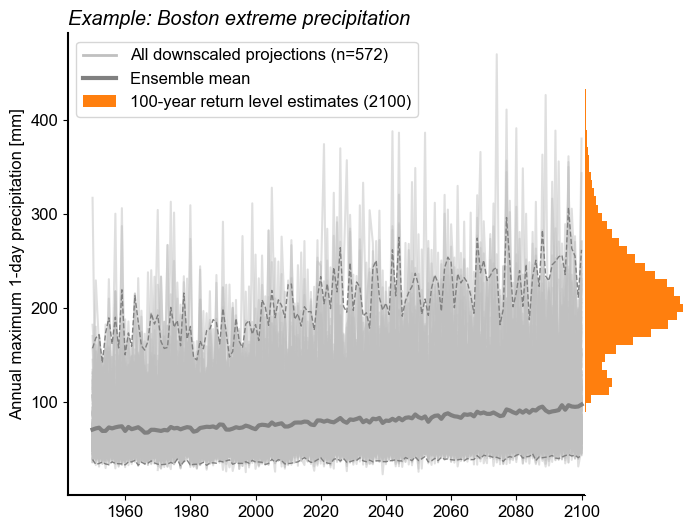

In [26]:
df_indexed = df.set_index(['gcm', 'ssp', 'member', 'ensemble']).sort_index()
unique_combos = df_indexed.index.unique()

fig, axs = plt.subplots(1,2, figsize=(8,6),
                        gridspec_kw={'width_ratios':[5,1], 'wspace':0.0})

# TS
ax = axs[0]
for combo in unique_combos[::2]:
    # Get entries
    gcm, ssp, member, ensemble = combo
    if ssp == 'historical':
        continue
    # Subset
    df_sel = df[(df['ensemble'] == ensemble) & (df['gcm'] == gcm) & (df['member'] == member) & (df['ssp'].isin([ssp, 'historical']))]
    df_sel.sort_values('time').plot(x='time', y=var_id, color='silver', alpha=0.5, ax=ax, legend=None)

df.groupby('time').mean(numeric_only=True).plot(y=var_id, lw=3, color='gray', ax=ax)
df.groupby('time').quantile(0.99, numeric_only=True).plot(y=var_id, lw=1, color='gray', ax=ax, ls='--')
df.groupby('time').quantile(0.01, numeric_only=True).plot(y=var_id, lw=1, color='gray', ax=ax, ls='--')

ax.set_xlabel("")
ax.set_ylabel(f"{pu.title_labels[metric_id]} {unit}")
ax.set_title(
        f"Example: Boston extreme precipitation",
        loc="left",
        fontstyle="italic",
)
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlim(ax.get_xlim()[0], 2101)

# Legend
legend_elements = [Line2D([0], [0], color='silver', lw=2, label=f'All downscaled projections (n={len(unique_combos)})'),
                   Line2D([0], [0], color='gray', lw=3, label=f'Ensemble mean'),
                   Patch(facecolor='C1', label='100-year return level estimates (2100)')]
ax.legend(handles=legend_elements, loc='upper left')

# Return levels
ax=axs[1]
ax.spines[["right", "top", "bottom", "left"]].set_visible(False)
df_nonstat['100yr_return_level_2100'].plot.hist(orientation='horizontal', bins=100, color='C1', histtype='barstacked')
ax.set_xlabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(axs[0].get_ylim())

plt.savefig('../figs/boston_pr_example_RL.png', dpi=600, bbox_inches='tight')

In [13]:
def plot_gev_uncertainty(
    df,
    metric_id,
    unit,
    ax,
    title_index="e)",
    city="chicago",
    ensemble="STAR-ESDM",
    gcm="ACCESS-CM2",
    ssp="ssp585",
    member="r1i1p1f1",
    col_name="100yr_return_level",
    ylims=None,
    xtext=0.99,
    ytext=0.02,
    include_stat_fit=True,
):
    var_id = metric_id.split("_")[1]
    df_sel = df[
        (df["gcm"] == gcm)
        & (df["ssp"] == ssp)
        & (df["ensemble"] == ensemble)
        & (df["member"] == member)
    ]
    ssp_name = pu.ssp_labels[ssp]

    # Read RLs
    stat_n_boot = 1000
    nonstat_n_boot = 1000
    sample_str = "_samples"
    stat_fit_method = "lmom"
    nonstat_fit_method = "mle"
    proj_slice = "2050-2100"
    hist_slice = "1950-2014"
    nonstat_slice = "1950-2100"

    # Read both fits
    df_stat = pd.read_csv(
        f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{stat_fit_method}_stat_nbootproj{stat_n_boot}_nboothist1{sample_str}.csv"
    )
    df_stat_sel = df_stat[
        (df_stat["gcm"] == gcm)
        & (df_stat["ssp"] == ssp)
        & (df_stat["ensemble"] == ensemble)
        & (df_stat["member"] == member)
    ]

    df_nonstat = pd.read_csv(
        f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{nonstat_slice}_{nonstat_fit_method}_nonstat_nboot{nonstat_n_boot}{sample_str}.csv"
    )
    df_nonstat_sel = df_nonstat[
        (df_nonstat["gcm"] == gcm)
        & (df_nonstat["ssp"] == ssp)
        & (df_nonstat["ensemble"] == ensemble)
        & (df_nonstat["member"] == member)
    ]
    df_nonstat_sel_main = df_nonstat_sel[df_nonstat_sel["n_boot"] == "main"]

    # Plot
    ax.plot(df_sel["time"], df_sel[var_id], color="black", label='Downscaled projection')

    # Proj
    if include_stat_fit:
        ax.fill_between(
            x=[2050, 2100],
            y1=[df_stat_sel[f"{col_name}_proj"].quantile(0.975)],
            y2=[df_stat_sel[f"{col_name}_proj"].quantile(0.025)],
            color="C0",
            alpha=0.5,
        )
        ax.hlines(
            df_stat_sel[f"{col_name}_proj"].median(),
            2050,
            2100,
            colors="C0",
            ls="--",
            label="Stationary (2050-2100)",
        )
        y1 = df_stat_sel[f"{col_name}_proj"].quantile(0.975)
        y2 = df_stat_sel[f"{col_name}_proj"].quantile(0.025)
        ax.annotate(
            "",
            xy=(2103, y1),
            xytext=(2103, y2),
            textcoords="data",
            arrowprops=dict(arrowstyle="<->", lw=1.5, color="C0", shrinkA=0, shrinkB=0),
        )

    # Non-stationary
    years = [1950, 1975, 2000, 2050, 2075, 2100]
    ax.plot(
        years,
        df_nonstat_sel_main[[f"{col_name}_{year}" for year in years]]
        .to_numpy()
        .flatten(),
        color="C1",
        ls="dotted",
        label="Non-stationary (1950-2100)",
    )

    ax.fill_between(
        x=years,
        y1=df_nonstat_sel[[f"{col_name}_{year}" for year in years]].quantile(0.975),
        y2=df_nonstat_sel[[f"{col_name}_{year}" for year in years]].quantile(0.025),
        color="C1",
        alpha=0.5,
    )
    y1 = df_nonstat_sel[f"{col_name}_2100"].quantile(0.975)
    y2 = df_nonstat_sel[f"{col_name}_2100"].quantile(0.025)
    # ax.annotate(
    #     "",
    #     xy=(2106, y1),
    #     xytext=(2106, y2),
    #     textcoords="data",
    #     arrowprops=dict(arrowstyle="<->", lw=1.5, color="C1", shrinkA=0, shrinkB=0),
    # )

    # Tidy
    if ylims is not None:
        ax.set_ylim(ylims)

    ax.set_xlabel("")
    ax.set_ylabel(f"{pu.title_labels[metric_id]} {unit}")
    ax.set_title(
        f"Example: Boston extreme heat",
        loc="left",
        fontstyle="italic",
    )
    ax.text(
        xtext,
        ytext,
        f"({ensemble}, {gcm}, {member}, {ssp_name})",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.spines[["right", "top"]].set_visible(False)
    ax.legend()

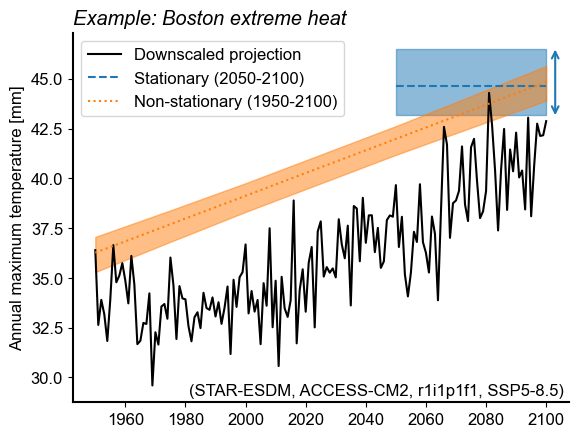

In [14]:
fig, ax = plt.subplots()
plot_gev_uncertainty(df, metric_id, unit, ax, city='boston', title_index="", include_stat_fit=True)
plt.savefig('../figs/boston_example_withstat.pdf', bbox_inches='tight')

In [56]:
def plot_scenario_uncertainty(
    df,
    metric_id,
    unit,
    ax,
    title_index="a)",
    ylims=None,
    xtext=0.99,
    ytext=0.02,
    ensemble="STAR-ESDM",
    gcm = 'IPSL-CM6A-LR',
):
    # Get variable name
    var_id = metric_id.split("_")[1]

    # Get SSP data
    df_ssp245 = df[(df["ssp"] == "ssp245") & (df["ensemble"] == ensemble) & (df['gcm'] == gcm)]
    df_ssp585 = df[(df["ssp"] == "ssp585") & (df["ensemble"] == ensemble) & (df['gcm'] == gcm)]

    # Plot all
    df_ssp245.query("time <= 2015").plot(
        x='time', y="tasmax", legend=None, color="gray", lw=2, ax=ax, label='Historical'
    )
    df_ssp585.query("time > 2015").plot(
        x='time', y="tasmax", label="SSP5-8.5", lw=2, ax=ax, color='sienna'
    )
    df_ssp245.query("time > 2015").plot(
        x='time', y="tasmax", label="SSP2-4.5", lw=2, ax=ax, color='lightsalmon'
    )

    # Tidy
    ax.set_xlabel("")
    ax.set_ylabel(f"{pu.title_labels[metric_id]} {unit}")
    ax.set_title(f"{title_index} Scenario uncertainty", loc="left", style="italic")
    ax.text(
        xtext,
        ytext,
        f"({ensemble}, {gcm})",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.spines[["right", "top"]].set_visible(False)
    if ylims is not None:
        ax.set_ylim(ylims)

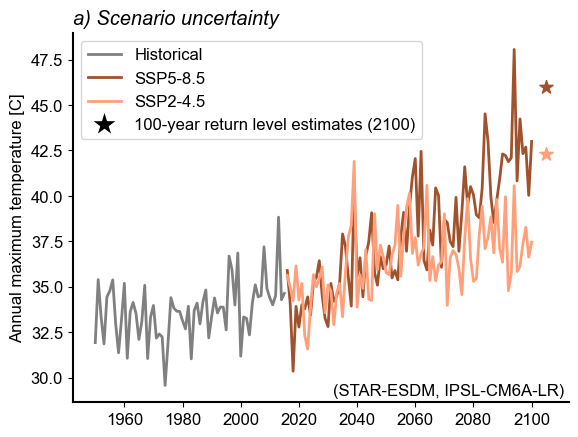

In [111]:
fig, ax = plt.subplots()

# Plot TS
plot_scenario_uncertainty(df, metric_id, unit, ax)

# Plot RLs
ssp585_rl = df_nonstat[(df_nonstat['ensemble'] == 'STAR-ESDM') & (df_nonstat['gcm'] == 'IPSL-CM6A-LR') & (df_nonstat['n_boot'] == 'main') & (df_nonstat['ssp'] == 'ssp585')]['100yr_return_level_2100'].iloc[0]
ssp245_rl = df_nonstat[(df_nonstat['ensemble'] == 'STAR-ESDM') & (df_nonstat['gcm'] == 'IPSL-CM6A-LR') & (df_nonstat['n_boot'] == 'main') & (df_nonstat['ssp'] == 'ssp245')]['100yr_return_level_2100'].iloc[0]

ax.scatter(x=[2105], y=[ssp245_rl], color='lightsalmon', zorder=2, marker='*', s=100)
ax.scatter(x=[2105], y=[ssp585_rl], color='sienna', zorder=2, marker='*', s=100)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], marker='*', color='white', label='100-year return level estimates (2100)', markerfacecolor='black', markersize=20),)
ax.legend(handles=handles)

plt.savefig('../figs/boston_scen.pdf', bbox_inches='tight')

In [77]:
def plot_response_uncertainty(
    df,
    metric_id,
    unit,
    ax,
    ylims=None,
    xtext=0.99,
    ytext=0.02,
    ensemble="STAR-ESDM",
    ssp="ssp585",
    title_index="b)",
):
    var_id = metric_id.split("_")[1]
    ssp_name = pu.ssp_labels[ssp]

    # Plot all
    df_sel = df[(df["ssp"].isin([ssp, 'historical'])) & (df["ensemble"] == ensemble)]
    
    for gcm in df_sel['gcm'].unique():
        df_gcm = df_sel[df_sel['gcm'] == gcm]
        if len(df_gcm["member"].unique()) >= 1:
            df_plot_sel = df_gcm.groupby('time').mean(numeric_only = True).sort_index()
            ax.plot(df_plot_sel.index, df_plot_sel[var_id], color="gray", alpha=0.5)

    # Tidy
    ax.set_xlabel("")
    ax.set_ylabel(f"{pu.title_labels[metric_id]} {unit}")
    ax.set_title(f"{title_index} Response uncertainty", loc="left", style="italic")
    ax.text(
        xtext,
        ytext,
        f"({ensemble}, {ssp_name})",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.spines[["right", "top"]].set_visible(False)
    if ylims is not None:
        ax.set_ylim(ylims)

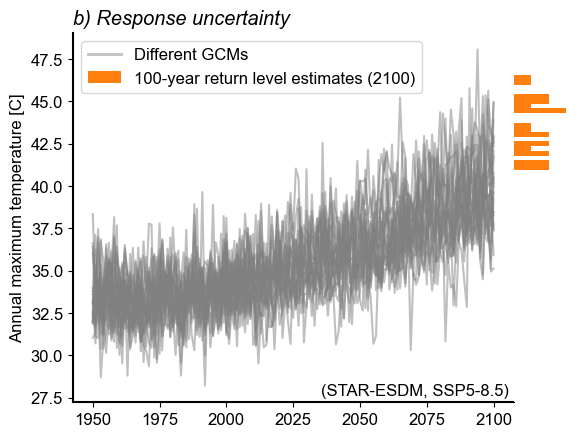

In [112]:
fig, axs = plt.subplots(1,2,
                        gridspec_kw={'width_ratios':[8,1], 'wspace':0.0})

# Plot TS
plot_response_uncertainty(df, metric_id, unit, axs[0])

# Legend
legend_elements = [Line2D([0], [0], color='silver', lw=2, label='Different GCMs'),
                   Patch(facecolor='C1', label='100-year return level estimates (2100)')]
axs[0].legend(handles=legend_elements, loc='upper left')

# Plot RLs
df_nonstat_sel = df_nonstat[(df_nonstat["ssp"] == 'ssp585') & (df_nonstat["ensemble"] == 'STAR-ESDM') & (df_nonstat["n_boot"] == 'main')]
ax=axs[1]
ax.spines[["right", "top", "bottom", "left"]].set_visible(False)
df_nonstat_sel['100yr_return_level_2100'].plot.hist(orientation='horizontal', bins=20, color='C1', histtype='barstacked')
ax.set_xlabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(axs[0].get_ylim())

plt.savefig('../figs/boston_response.png', dpi=300, bbox_inches='tight')

In [79]:
def plot_internal_variability(
    df,
    metric_id,
    unit,
    ax,
    title_index="c)",
    ensemble="GARD-LENS",
    ssp="ssp370",
    gcm="CESM2-LENS",
    ylims=None,
    xtext=0.99,
    ytext=0.02,
):
    var_id = metric_id.split("_")[1]
    ssp_name = pu.ssp_labels[ssp]

    df_gcm = df[(df["ssp"] == ssp) & (df["ensemble"] == ensemble) & (df["gcm"] == gcm)]

    # Plot all
    for member in df_gcm["member"].unique():
        df_plot_sel = df_gcm[df_gcm["member"] == member].sort_values("time")
        ax.plot(df_plot_sel["time"], df_plot_sel[var_id], color="silver", alpha=0.5)

    # Add mean
    df_gcm.groupby("time").mean(numeric_only=True)[var_id].plot(
        color="gray", label=gcm, lw=2, ax=ax
    )

    # Tidy
    ax.set_xlabel("")
    ax.set_ylabel(f"{pu.title_labels[metric_id]} {unit}")
    ax.set_title(f"{title_index} Internal variability", loc="left", style="italic")
    ax.text(
        xtext,
        ytext,
        f"({ensemble}, {ssp_name})",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.spines[["right", "top"]].set_visible(False)
    ax.legend()
    if ylims is not None:
        ax.set_ylim(ylims)

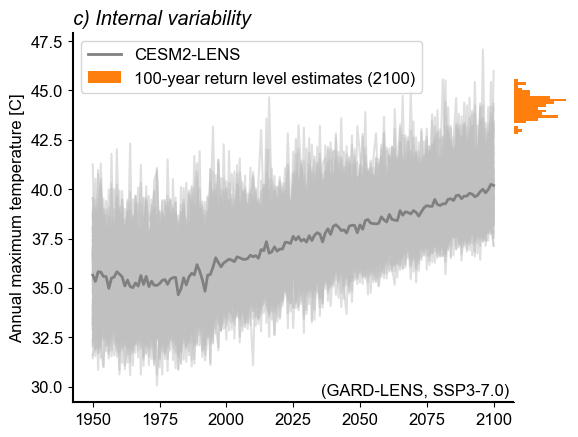

In [113]:
fig, axs = plt.subplots(1,2,
                        gridspec_kw={'width_ratios':[8,1], 'wspace':0.0})

# Plot TS
plot_internal_variability(df, metric_id, unit, axs[0])

# Legend
handles, labels = axs[0].get_legend_handles_labels()
handles.append(Patch(facecolor='C1', label='100-year return level estimates (2100)'))
axs[0].legend(handles=handles)

# Plot RLs
ax=axs[1]
df_nonstat_sel = df_nonstat[(df_nonstat["ssp"] == 'ssp370') & (df_nonstat["ensemble"] == 'GARD-LENS') & (df_nonstat["n_boot"] == 'main') & (df_nonstat["gcm"] == 'CESM2-LENS')]
ax.spines[["right", "top", "bottom", "left"]].set_visible(False)
df_nonstat_sel['100yr_return_level_2100'].plot.hist(orientation='horizontal', bins=20, color='C1', histtype='barstacked')
ax.set_xlabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(axs[0].get_ylim())

plt.savefig('../figs/boston_iv.png', dpi=400, bbox_inches='tight')

In [104]:
def plot_downscaling_uncertainty(
    df,
    metric_id,
    unit,
    ax,
    title_index="d)",
    gcm="CanESM5",
    ssp="ssp370",
    ensemble1="GARD-LENS",
    ensemble2="LOCA2",
    member="r3i1p1f1",
    ylims=None,
    xtext=0.99,
    ytext=0.02,
):
    var_id = metric_id.split("_")[1]
    ssp_name = pu.ssp_labels[ssp]

    df_ensemble1 = df[
        (df["ssp"] == ssp)
        & (df["ensemble"] == ensemble1)
        & (df["gcm"] == gcm)
        & (df["member"] == member)
    ]
    df_ensemble2 = df[
        (df["ssp"].isin([ssp, "historical"]))
        & (df["ensemble"] == ensemble2)
        & (df["gcm"] == gcm)
        & (df["member"] == member)
    ]

    # Plot all
    ax.plot(df_ensemble1["time"], df_ensemble1[var_id], label=ensemble1, lw=2, color='turquoise')
    ax.plot(df_ensemble2["time"], df_ensemble2[var_id], label=ensemble2, lw=2, color='darkgreen')

    # Tidy
    ax.set_xlabel("")
    ax.set_ylabel(f"{pu.title_labels[metric_id]} {unit}")
    ax.set_title(f"{title_index} Downscaling uncertainty", loc="left", style="italic")
    ax.text(
        xtext,
        ytext,
        f"({gcm}, {member}, {ssp_name})",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.spines[["right", "top"]].set_visible(False)
    ax.legend()
    if ylims is not None:
        ax.set_ylim(ylims)

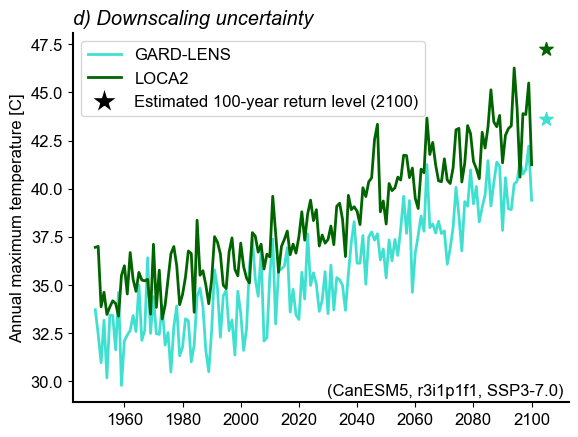

In [107]:
fig, ax = plt.subplots()

# Plot TS
plot_downscaling_uncertainty(df, metric_id, unit, ax)

# Plot RLs
ssp585_gard_lens = df_nonstat[(df_nonstat['ensemble'] == 'GARD-LENS') & (df_nonstat['gcm'] == 'CanESM5') & (df_nonstat['n_boot'] == 'main') & (df_nonstat['ssp'] == 'ssp370')]['100yr_return_level_2100'].iloc[0]
ssp245_loca = df_nonstat[(df_nonstat['ensemble'] == 'LOCA2') & (df_nonstat['gcm'] == 'CanESM5') & (df_nonstat['n_boot'] == 'main') & (df_nonstat['ssp'] == 'ssp370')]['100yr_return_level_2100'].iloc[0]

ax.scatter(x=[2105], y=[ssp585_gard_lens], color='turquoise', zorder=2, marker='*', s=100)
ax.scatter(x=[2105], y=[ssp245_loca], color='darkgreen', zorder=2, marker='*', s=100)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], marker='*', color='white', label='Estimated 100-year return level (2100)', markerfacecolor='black', markersize=20),)
ax.legend(handles=handles)

plt.savefig('../figs/boston_ds.pdf', bbox_inches='tight')

In [114]:
import sa_city_utils as sacu

In [168]:
# Read return levels
city = 'boston'
metric_id = 'max_tasmax'
stat_n_boot = 1000
nonstat_n_boot = 1000
sample_str = "_samples"
stat_fit_method = "lmom"
nonstat_fit_method = "mle"
proj_slice = "2050-2100"
hist_slice = "1950-2014"
nonstat_slice = "1950-2100"

df_nonstat = pd.read_csv(
        f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{nonstat_slice}_{nonstat_fit_method}_nonstat_nboot{nonstat_n_boot}{sample_str}.csv"
)

In [177]:
# Results
df_uc = sacu.calculate_df_uc(df_nonstat, '100yr_return_level_diff_2075-1975')

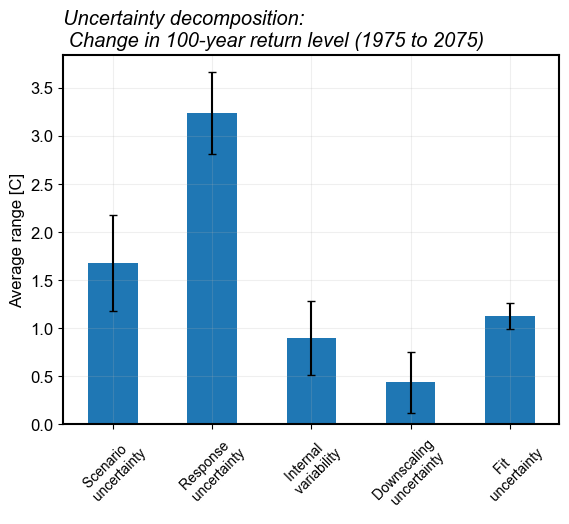

In [179]:
fig, ax = plt.subplots()

uc_names = [
        "Scenario \n uncertainty",
        "Response \n uncertainty",
        "Internal \n variability",
        "Downscaling \n uncertainty",
        "Fit \n uncertainty",
    ]

df_uc[~df_uc["uncertainty_type"].isin(["ssp_uc", "uc_99w"])].plot.bar(
        x="uncertainty_type", y="mean", yerr="std", ax=ax, legend=False, capsize=3,
)

# Tidy
ax.set_xticklabels(uc_names, rotation=45, fontsize=10)
ax.set_title('Uncertainty decomposition: \n Change in 100-year return level (1975 to 2075)', style='italic', loc='left')
ax.set_ylabel(f"Average range [C]")
ax.set_xlabel("")
ax.grid(alpha=0.2, zorder=3)
ax.set_ylim([0, ax.get_ylim()[1]])
plt.savefig('../figs/boston_tasmax_uc_diff.pdf', bbox_inches='tight')

### Climate info

In [9]:
# Get all climate info
out = []
for metric_id in gev_metric_ids:
    #### LOCA2
    ensemble = "LOCA2"
    df_loca = get_unique_loca_metrics(metric_id)

    # Loop through
    delayed = []
    for index, row in df_loca.iterrows():
        # Get info
        gcm, member, ssp = row["gcm"], row["member"], row["ssp"]
        if ssp == "historical":
            continue
        out.append(
            pd.DataFrame(
                {"ensemble": [ensemble], "gcm": [gcm], "member": [member], "ssp": [ssp]}
            )
        )

    #### STAR-ESDM
    ensemble = "STAR-ESDM"
    files = glob(f"{project_data_path}/metrics/{ensemble}/{metric_id}_*")

    # Loop through
    for file in files:
        # Get info
        _, _, gcm, member, ssp = file.split("/")[-1].split(".")[0].split("_")

        # Fit for historical and ssp
        for ssp_id in ["historical", ssp]:
            if ssp_id == "historical":
                continue
            out.append(
                pd.DataFrame(
                    {
                        "ensemble": [ensemble],
                        "gcm": [gcm],
                        "member": [member],
                        "ssp": [ssp],
                    }
                )
            )

    #### GARD-LENS
    ensemble = "GARD-LENS"
    files = glob(f"{project_data_path}/metrics/{ensemble}/{metric_id}_*")

    # Loop through
    for file in files:
        # Get info
        info = file.split("/")[-1].split("_")
        gcm = info[2]
        ssp = info[-1].split(".")[0]
        member = f"{info[3]}_{info[4]}" if gcm == "cesm2" else info[3]

        # Do for historical and ssp
        for ssp_id in ["historical", ssp]:
            if ssp_id == "historical":
                continue
            out.append(
                pd.DataFrame(
                    {
                        "ensemble": [ensemble],
                        "gcm": [gcm],
                        "member": [member],
                        "ssp": [ssp],
                    }
                )
            )

# Store all
pd.concat(out, ignore_index=True).drop_duplicates().to_csv(
    f"{project_data_path}/ensemble_info.csv", index=False
)

### Maps

In [45]:
# Example
gcm = "CanESM5"
ssp = "ssp370"
member = "r1i1p1f1"

ds_loca = xr.open_dataset(
    "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/LOCA2/max_pr_CanESM5_r1i1p1f1_ssp370_2045-2074.nc"
)
ds_gard = xr.open_dataset(
    "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/GARD-LENS/max_pr_canesm5_r1i1p1f1_ssp370.nc"
)

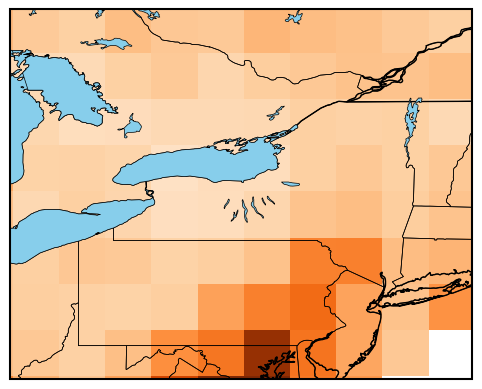

In [58]:
# Create the figure and axis with projection
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the data
ds_gard.sel(time="2050-12-31")["pr"].coarsen(lat=8, lon=8, boundary="pad").mean().plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap="Oranges", vmax=190
)
ax.set_title("")
ax.set_extent([-82, -72, 39, 47], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, facecolor="skyblue", edgecolor="black", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

plt.show()

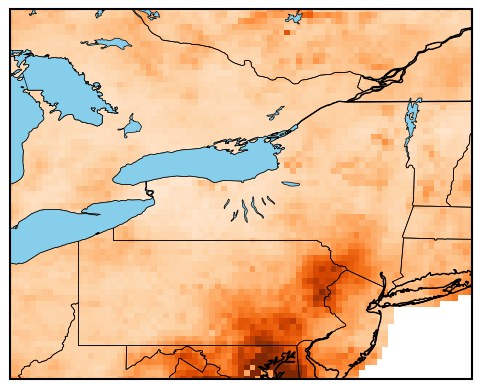

In [52]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the figure and axis with projection
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the data
ds_gard.sel(time="2050-12-31")["pr"].plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap="Oranges", vmax=190
)
ax.set_title("")
ax.set_extent([-82, -72, 39, 47], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, facecolor="skyblue", edgecolor="black", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

plt.show()

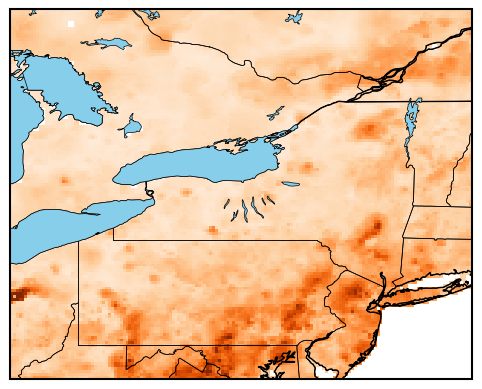

In [51]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the figure and axis with projection
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the data
ds_loca.sel(time="2050-12-31")["pr"].plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap="Oranges", vmax=190
)
ax.set_title("")
ax.set_extent([-82, -72, 39, 47], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, facecolor="skyblue", edgecolor="black", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

plt.show()

### Map plot

In [61]:
ds = xr.open_dataset(
    "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/max_pr/GARD-LENS_canesm5_r10i1p1f1_ssp370_2050-2100_stat_lmom.nc"
)

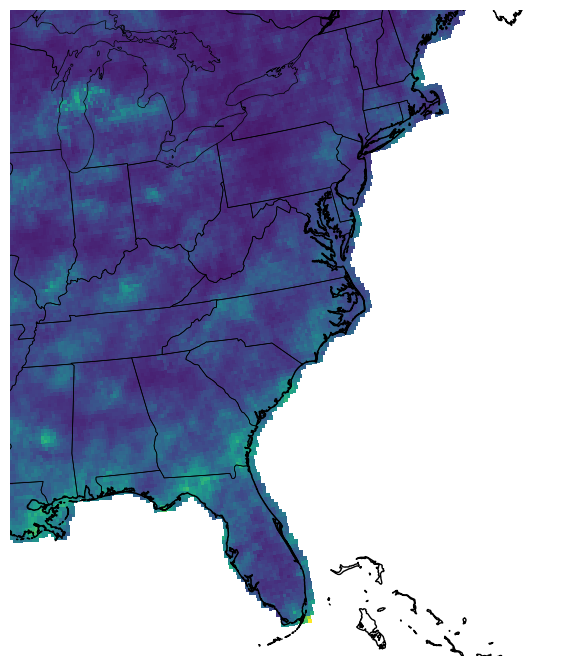

In [65]:
fig, ax = plt.subplots(
    subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(6, 8)
)

ds["100yr_return_level"].plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", add_colorbar=False
)

# Tidy
ax.set_extent([-90, -70, 25, 45], ccrs.Geodetic())
ax.coastlines(resolution="10m")
ax.set_title("")
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.25)
ax.axis("off")
plt.tight_layout()
plt.savefig("../figs/map_example.png", dpi=600)

### Timeseries with RL

In [13]:
# Read timeseries
metric_id = "max_tasmax"
gcm = "CanESM5"
ssp = "ssp370"
ensemble = "LOCA2"
member = "r1i1p1f1"

city = "nyc"
lat, lon = city_list[city]

ds_fut = xr.open_mfdataset(
    f"{project_data_path}/metrics/LOCA2/{metric_id}_{gcm}_{member}_{ssp}_*.nc"
).sel(lat=lat, lon=360 + lon, method="nearest")
ds_hist = xr.open_mfdataset(
    f"{project_data_path}/metrics/LOCA2/{metric_id}_{gcm}_{member}_historical_*.nc"
).sel(lat=lat, lon=360 + lon, method="nearest")

ds_gard = xr.open_dataset(
    f"{project_data_path}/metrics/GARD-LENS/{metric_id}_canesm5_{member}_{ssp}.nc"
).sel(lat=lat, lon=lon, method="nearest")

In [5]:
# Read RLs
ds_rl_fut = xr.open_dataset(
    f"{project_data_path}/extreme_value/original_grid/{metric_id}/{ensemble}_{gcm}_{member}_{ssp}_2050-2100_stat_lmom.nc"
).sel(lat=lat, lon=360 + lon, method="nearest")
ds_rl_hist = xr.open_dataset(
    f"{project_data_path}/extreme_value/original_grid/{metric_id}/{ensemble}_{gcm}_{member}_historical_1950-2014_stat_lmom.nc"
).sel(lat=lat, lon=360 + lon, method="nearest")

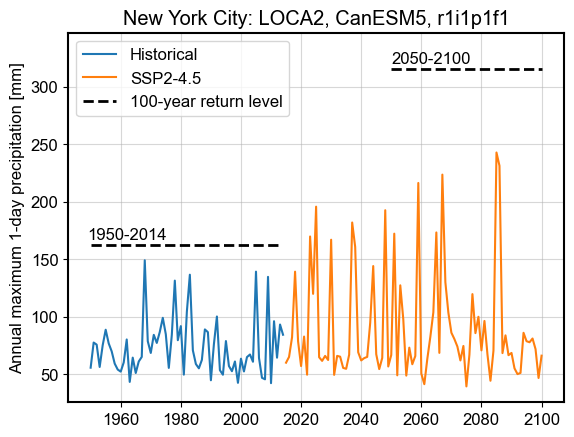

In [24]:
fig, ax = plt.subplots()

# Hist
ax.plot(np.arange(1950, 2015), ds_hist["pr"], label="Historical", color="C0")

ax.hlines(ds_rl_hist["100yr_return_level"], 1950, 2013, colors="black", ls="--", lw=2)
ax.text(1949, ds_rl_hist["100yr_return_level"] + 5, "1950-2014")

# Proj
ax.plot(
    np.arange(2015, 2101),
    ds_fut["pr"].sel(time=slice("2015", "2101")),
    label="SSP2-4.5",
    color="C1",
)

ax.hlines(
    ds_rl_fut["100yr_return_level"],
    2050,
    2100,
    colors="black",
    ls="--",
    lw=2,
    label="100-year return level",
)
ax.text(2050, ds_rl_fut["100yr_return_level"] + 5, "2050-2100")

ax.set_xlabel("")
ax.set_ylabel("Annual maximum 1-day precipitation [mm]")
ax.grid(alpha=0.5)
ax.set_title(f"New York City: {ensemble}, {gcm}, {member}")
ax.set_ylim([ax.get_ylim()[0], ds_rl_fut["100yr_return_level"] * 1.1])
ax.legend()

plt.savefig("../figs/nyc_timeseries_example.pdf")

### NYC plots

In [95]:
ssp_colors = {
    "ssp245": "#1b9e77",
    "ssp370": "#7570b3",
    "ssp585": "#d95f02",
}
ssp_labels = {
    "ssp245": "Medium",
    "ssp370": "High",
    "ssp585": "Extreme",
}

In [96]:
df_cdd = (
    pd.read_csv(
        "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/cities/nyc_max_cdd.csv"
    )
    .groupby(["gcm", "member", "ssp", "ensemble"])["cdd"]
    .max()
    .reset_index()
)
df_hdd = (
    pd.read_csv(
        "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/cities/nyc_max_hdd.csv"
    )
    .groupby(["gcm", "member", "ssp", "ensemble"])["hdd"]
    .max()
    .reset_index()
)

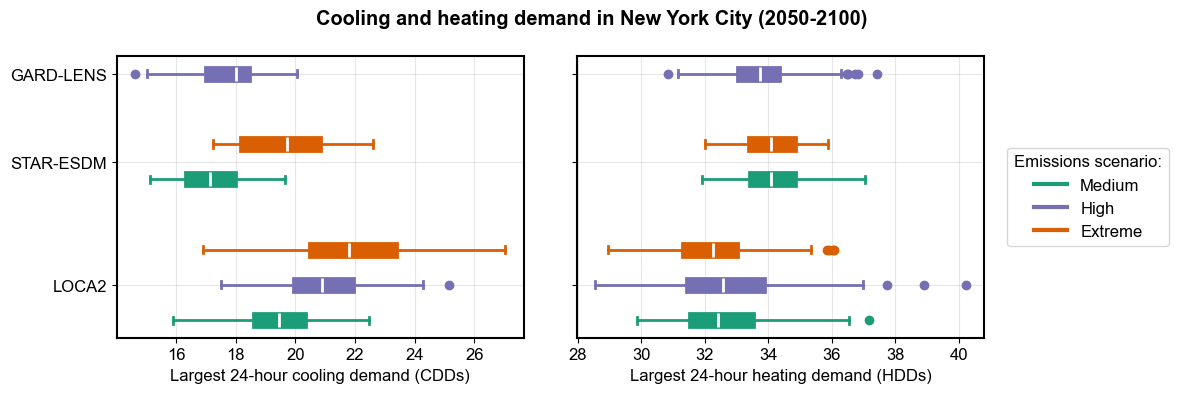

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, width_ratios=[4, 4, 1])

fig.suptitle(
    "Cooling and heating demand in New York City (2050-2100)", fontweight="bold"
)

#########
# CDD
df = df_cdd.copy()
ax = axs[0]

# Filter
df_sel = df[(df["ssp"] != "historical") & (df["gcm"] != "TaiESM1")]

# Plot
idy = 0

for ensemble in df_sel["ensemble"].unique():
    idy += 1
    df_ens_sel = df_sel[df_sel["ensemble"] == ensemble]
    for ssp in df_ens_sel["ssp"].unique():
        pu.plot_boxplot(
            df_ens_sel[df_ens_sel["ssp"] == ssp],
            "cdd",
            [idy],
            ssp_colors[ssp],
            ax,
            lw=2,
        )
        idy += 1

# Manual labels
ax.set_yticks([2, 5.5, 8], ["LOCA2", "STAR-ESDM", "GARD-LENS"])
ax.grid(alpha=0.3)
ax.set_xlabel("")
ax.set_xlabel("Largest 24-hour cooling demand (CDDs)")

##############
# HDD
df = df_hdd.copy()
ax = axs[1]

# Filter
df_sel = df[(df["ssp"] != "historical") & (df["gcm"] != "TaiESM1")]

# Plot
idy = 0

for ensemble in df_sel["ensemble"].unique():
    idy += 1
    df_ens_sel = df_sel[df_sel["ensemble"] == ensemble]
    for ssp in df_ens_sel["ssp"].unique():
        pu.plot_boxplot(
            df_ens_sel[df_ens_sel["ssp"] == ssp],
            "hdd",
            [idy],
            ssp_colors[ssp],
            ax,
            lw=2,
        )
        idy += 1

# Manual labels
ax.set_yticks([2, 5.5, 8], ["LOCA2", "STAR-ESDM", "GARD-LENS"])
ax.grid(alpha=0.3)
ax.set_xlabel("Largest 24-hour heating demand (HDDs)")

########## Add legend
legend_elements = [
    Line2D([0], [0], color=ssp_colors[ssp], label=ssp_labels[ssp], lw=3)
    for ssp in ssp_colors.keys()
]
axs[2].legend(handles=legend_elements, title="Emissions scenario:", loc="center")
axs[2].axis("off")

plt.tight_layout()
plt.savefig("../figs/nyc_cooling_heating_2050-2100.png", dpi=400)